<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Проверка-качества-данных" data-toc-modified-id="Проверка-качества-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Проверка качества данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve, recall_score
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

In [40]:
data = pd.read_csv('/datasets/Churn.csv')

In [41]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Проверка качества данных

**Поиск дубликатов**

In [43]:
#==================
#  Полные дубликаты
#==================

data.duplicated().sum()

0

In [44]:
#=========================
#  Дубликаты по CustomerId
#=========================

data.duplicated(subset=['CustomerId']).sum()

0

**Обработка пропусков**

In [45]:
data.Tenure.value_counts(dropna=False, normalize=True)

1.0     0.0952
2.0     0.0950
8.0     0.0933
3.0     0.0928
5.0     0.0927
7.0     0.0925
NaN     0.0909
4.0     0.0885
9.0     0.0882
6.0     0.0881
10.0    0.0446
0.0     0.0382
Name: Tenure, dtype: float64

**Вывод:**<br>
Колонка <code>Tenure</code> содержит примерно 9% пропусков (909 штук)

<ins>*Рекомендация*</ins>: <br>
Заполнить пропуски медианным значеним

In [46]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

**Проверка на выбросы**

In [47]:
percenliles = [0.1, 0.25, 0.5, 0.75, 0.9]
data.describe(percenliles)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.99790,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.76001,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.00000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
10%,1000.90000,1.559117e+07,521.000000,27.000000,1.00000,0.000000,1.000000,0.00000,0.000000,20273.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.00000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.00000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.00000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
90%,9000.10000,1.579083e+07,778.000000,53.000000,9.00000,149244.792000,2.000000,1.00000,1.000000,179674.704000,1.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.00000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Вывод:**<br>
Выбросов не обнаружено

### Подготовка данных

In [48]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Удаление ненужных колонок**

In [49]:
unnecessary_columns = ['RowNumber', 'Surname', 'CustomerId']
data = data.drop(unnecessary_columns, axis=1)

**Обработка категориальных переменных**

In [50]:
data_ohe = pd.get_dummies(data, columns=['Gender'], drop_first=True)
data_ohe = pd.get_dummies(data_ohe, columns=['Geography'])

In [51]:
data_ohe.sample(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
1600,517,28,2.0,115062.61,1,1,0,179056.23,0,1,1,0,0
4604,681,25,5.0,0.00,1,0,1,90860.97,0,1,1,0,0
7736,649,41,3.0,130931.83,1,1,1,144808.37,0,0,1,0,0
5073,644,34,9.0,112746.54,2,0,0,141230.07,0,1,0,1,0
8490,746,48,5.0,165282.42,1,1,0,153786.46,1,1,1,0,0


**Разбиение выборки**

In [52]:
X = data_ohe.drop(['Exited'], axis=1)
y = data_ohe['Exited']

X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.4, random_state=1234)
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=1234)

In [53]:
print('Размер train:', X_train.shape[0] / X.shape[0])
print('Размер valid:',X_valid.shape[0] / X.shape[0])
print('Размер test:', X_test.shape[0] / X.shape[0])

Размер train: 0.6
Размер valid: 0.2
Размер test: 0.2


**Масштабирование признаков**

In [54]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [55]:
scaler = StandardScaler()
scaler.fit(X_train[numeric])

StandardScaler()

In [56]:
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

**Вывод:**

В ходе подготовки данных были выполнены следующие шаги:
1. Столбцы <code>RowNumber</code>,<code>Surname</code> и <code>CustomerId</code> были удалены из выбрки
2. К столбцы <code>Gender</code> и <code>Geography</code> было применено прямое кодирование
3. К столбцам <code>CreditScore</code>, <code>Age</code>, <code>Tenure</code>, <code>Balance</code>, <code>NumOfProducts</code> и <code>EstimatedSalary</code> было применено масштабирование 
4. Исходная выборка была разделена на <ins>обучающуюю(60%)</ins>, <ins>валидационную(20%)</ins> и <ins>тестовую(20%)</ins>

## Исследование задачи

**Дисбаланс классов**

In [57]:
y_train.value_counts(normalize=True)

0    0.796333
1    0.203667
Name: Exited, dtype: float64

**Вывод:**<br>
Обучаюющая выборка содержит примерно 20% меток положительного класса

**Построение моделей без учета дисбаланса классов**

In [58]:
# Случайный лес
best_model = None
best_result = 0
for est in range(1, 11):
    for depth in range(1, 10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est) # обучите модель с заданным количеством деревьев
        model.fit(X_train, y_train) # обучите модель на тренировочной выборке
#         result = model.score(X_valid, y_valid) # посчитайте качество модели на валидационной выборке
        result = f1_score(y_valid, model.predict(X_valid))
        if result > best_result:
            best_model_rf = model# сохраните наилучшую модель
            best_result = result#  сохраните наилучшее значение метрики accuracy на валидационных данных

# print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("F1-score наилучшей модели на валидационной выборке:", f1_score(y_valid, best_model_rf.predict(X_valid)))
print("ROC-AUC наилучшей модели на валидационной выборке:", roc_auc_score(y_valid, best_model_rf.predict_proba(X_valid)[:, 1]))

F1-score наилучшей модели на валидационной выборке: 0.541471048513302
ROC-AUC наилучшей модели на валидационной выборке: 0.8156156652866576


In [59]:
# Логистическая регрессия
best_model_lr = None
best_result = 0
C_param_range = [0.001,0.01,0.1,1,10,100]
for c in C_param_range:
    model = lr = LogisticRegression(C=c, random_state=1234) # обучите модель с заданным количеством деревьев
    model.fit(X_train, y_train) # обучите модель на тренировочной выборке
#     result = model.score(X_valid, y_valid) # посчитайте качество модели на валидационной выборке
    result = f1_score(y_valid, model.predict(X_valid))
    if result > best_result:
        best_model_lr = model# сохраните наилучшую модель
        best_result = result#  сохраните наилучшее значение метрики accuracy на валидационных данных

# print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("F1-score наилучшей модели на валидационной выборке:", f1_score(y_valid, best_model_lr.predict(X_valid)))
print("ROC-AUC наилучшей модели на валидационной выборке:", roc_auc_score(y_valid, best_model_lr.predict_proba(X_valid)[:, 1]))

F1-score наилучшей модели на валидационной выборке: 0.3038461538461539
ROC-AUC наилучшей модели на валидационной выборке: 0.7618943900010482


In [60]:
# # Константная модель
# y_pred_constant = pd.Series([0]*X_valid.shape[0])
# print("Accuracy константной модели на валидационной выборке:",accuracy_score(y_valid, y_pred_constant))

**Вывод:**<br>

В ходе исследования на несбалансированной выборке строилось две модели:
* Модель логистической регресии 
* Модель случайного леса

Результаты исследования показали:

1. <ins>Качество (F1-мера и площадь под ROC-кривой):</ins> <br>
    Самое высокое качество у случайного леса: 
        F1-мера = 0.54 и площадь под ROC-кривой = 0.81
    Самое низкое качество предсказания у логистической регрессии: 
        F1-мера = 0.3 и площадь под ROC-кривой = 0.76


2. <ins>Скорость работы:</ins> <br>
    Высокая скорость работы у логистической регрессии: у неё меньше всего параметров.<br>
    Случайный лес медленнее всех: чем больше деревьев, тем неторопливее работает модель.<br>

<ins>Общий итог</ins>: На несбалансированной выборке не удалось достичь нужного значения F1-меры


<!-- Accuracy <ins>константной модели</ins> получиласть практически одинаковой с моделями *случайного леса* и *логистической регрессии*.<br>
В связи с чем можно сделать вывод, что <ins>модель не прошла проверку на адекавтность</ins>  -->

## Борьба с дисбалансом

**Взвешивание классов**

In [61]:
# Случайный лес
best_model_rf = None
best_result = 0
for est in range(1, 11):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced') # обучите модель с заданным количеством деревьев
    model.fit(X_train, y_train) # обучите модель на тренировочной выборке
#     result = model.score(X_valid, y_valid) # посчитайте качество модели на валидационной выборке
    result = f1_score(y_valid, model.predict(X_valid))
    if result > best_result:
        best_model_rf = model# сохраните наилучшую модель
        best_result = result#  сохраните наилучшее значение метрики accuracy на валидационных данных

print("F1-score наилучшей модели на валидационной выборке:", best_result)

F1-score наилучшей модели на валидационной выборке: 0.535031847133758


In [62]:
# Логистическая регрессия
best_model = None
best_result = 0
C_param_range = [0.001,0.01,0.1,1,10,100]
for c in C_param_range:
    model = lr = LogisticRegression(C=c, random_state=1234, class_weight='balanced') # обучите модель с заданным количеством деревьев
    model.fit(X_train, y_train) # обучите модель на тренировочной выборке
#     result = model.score(X_valid, y_valid) # посчитайте качество модели на валидационной выборке
    result = f1_score(y_valid, model.predict(X_valid))
    if result > best_result:
        best_model_lr = model# сохраните наилучшую модель
        best_result = result#  сохраните наилучшее значение метрики accuracy на валидационных данных

print("F1-score наилучшей модели на валидационной выборке:", best_result)

F1-score наилучшей модели на валидационной выборке: 0.46182846371347785


**Вывод:**<br>
Взвешивание классов не позволило довести метрику (f1_score) до 0.59<br>
Лучшее значение метрики (F1-мера = 0.535) достигается у модели случайного леса c <code>n_estimators=7</code>

**Изменение порога**

In [63]:
probabilities_valid = best_model_rf.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0.2, 0.6, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(y_valid, predicted_valid)
    print("Порог = {:.2f} | F1-мера = {:.3f}".format(threshold, f1))

Порог = 0.20 | F1-мера = 0.521
Порог = 0.22 | F1-мера = 0.521
Порог = 0.24 | F1-мера = 0.543
Порог = 0.26 | F1-мера = 0.543
Порог = 0.28 | F1-мера = 0.543
Порог = 0.30 | F1-мера = 0.543
Порог = 0.32 | F1-мера = 0.543
Порог = 0.34 | F1-мера = 0.551
Порог = 0.36 | F1-мера = 0.551
Порог = 0.38 | F1-мера = 0.551
Порог = 0.40 | F1-мера = 0.551
Порог = 0.42 | F1-мера = 0.551
Порог = 0.44 | F1-мера = 0.551
Порог = 0.46 | F1-мера = 0.535
Порог = 0.48 | F1-мера = 0.535
Порог = 0.50 | F1-мера = 0.535
Порог = 0.52 | F1-мера = 0.535
Порог = 0.54 | F1-мера = 0.535
Порог = 0.56 | F1-мера = 0.473
Порог = 0.58 | F1-мера = 0.473


**Вывод:**<br>
Изменение порога для лучшей модели случайного леса не позволило довести метрику (f1_score) до 0.59<br>
Лучшее значение метрики (F1-мера = 0.551) достигается при пороге = 0.44

**Увеличение выборки**

In [64]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [65]:
X_upsampled, y_upsampled = upsample(X_train, y_train, 4)

In [66]:
y_upsampled.value_counts(normalize=True)

1    0.50569
0    0.49431
Name: Exited, dtype: float64

In [67]:
# Случайный лес
# best_model_rf = None
# best_result = 0
# for est in range(1, 25):
#     for depth in range(1, 25):
#         model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # обучите модель с заданным количеством деревьев
#         model.fit(X_upsampled, y_upsampled) # обучите модель на тренировочной выборке
#     #     result = model.score(X_valid, y_valid) # посчитайте качество модели на валидационной выборке
#         result = f1_score(y_valid, model.predict(X_valid))
#         if result > best_result:
#             best_model_rf = model# сохраните наилучшую модель
#             best_result = result#  сохраните наилучшее значение метрики accuracy на валидационных данных

# print("F1-score наилучшей модели на валидационной выборке:", best_result)

F1-score наилучшей модели на валидационной выборке: 0.5956416464891041


In [68]:
# Логистическая регрессия
best_model_lr = None
best_result = 0
# C_param_range = [0.001,0.01,0.1,1,10,100]
C_param_range = [0.005,0.05,0.5,5,15,150]
for c in C_param_range:
    model = lr = LogisticRegression(C=c, random_state=1234) # обучите модель с заданным количеством деревьев
    model.fit(X_upsampled, y_upsampled) # обучите модель на тренировочной выборке
#     result = model.score(X_valid, y_valid) # посчитайте качество модели на валидационной выборке
    result = f1_score(y_valid, model.predict(X_valid))
    if result > best_result:
        best_model_lr = model# сохраните наилучшую модель
        best_result = result#  сохраните наилучшее значение метрики accuracy на валидационных данных

print("F1-score наилучшей модели на валидационной выборке:", best_result)

F1-score наилучшей модели на валидационной выборке: 0.46268656716417916


**Вывод:** 

Результаты исседований показали, что лучшей моделью (по результатам метрики f1_score) для этого набора данных будет случайный лес, обученного на "увеличенной выборке" со следующими гиперпарааметрами:
* <code>n_estimators=24</code>
* <code>max_depth=11</code>
* Все остальные гиперпармаетры остались без именений

## Тестирование модели

In [69]:
test_result_f1 = f1_score(y_test, best_model_rf.predict(X_test))
test_result_auc = roc_auc_score(y_test, best_model_rf.predict_proba(X_test)[:, 1])
test_result_recall = recall_score(y_test, best_model_rf.predict(X_test))
print("F1-score наилучшей модели на тестовой выборке:", test_result_f1)
print("ROC-AUC  наилучшей модели на тестовой выборке:", test_result_auc)
print("Recall   наилучшей модели на тестовой выборке:", test_result_recall)

F1-score наилучшей модели на тестовой выборке: 0.619934282584885
ROC-AUC  наилучшей модели на тестовой выборке: 0.8331015542574629
Recall   наилучшей модели на тестовой выборке: 0.6446469248291572


**ROC-кривая**

In [70]:
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

In [71]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

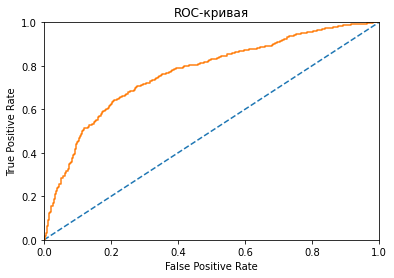

In [72]:
plt.figure()
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

**Вывод:**




Модель случайного леса показа на тестовой выборке следующие значения метрик:
* F1-мера = 0.619
* ROC-AUC = 0.833

**Коснтантная молель**

In [73]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(X_train, y_train)
# f1_score(dummy_model.predict(X_test), y_test)

test_result_f1 = f1_score(y_test, dummy_model.predict(X_test))
test_result_auc = roc_auc_score(y_test, dummy_model.predict_proba(X_test)[:, 1])
print("F1-score константной модели на тестовой выборке:", test_result_f1)
print("ROC-AUC  константной модели на тестовой выборке:", test_result_auc)

F1-score константной модели на тестовой выборке: 0.35998359983599837
ROC-AUC  константной модели на тестовой выборке: 0.5


**Общий вывод:**

Была построена модель, цель которой спрогнозировать уход клиента из банка, т.к. банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Входные данные - исторические данные о поведении клиентов и расторжении договоров с банком «Бета-Банк».

<br>

Необходимо было построить модель, которая имеет предельно большое значение F1-меры (не менне 0.59).

<br>

<ins>Результаты исседований показали:</ins> 

<br>

**Модель:**<br>
Лучшей моделью для этого набора данных будет случайный лес, обученный на "увеличенной выборке" со следующими гиперпараметрами:
* <code>n_estimators=24</code>
* <code>max_depth=11</code>
* Все остальные гиперпармаетры остались без именений

**Качество модели:**<br>
Для оценки качетва модели использовались метрики: F1-мера и площадь под ROC-кривой.<br>
Модель показала следующте результаты:
* Обучающая выборка:
        F1-мера = 0.865
        Площадь под ROC-кривой = 0.988
* Валидационная выборка:
        F1-мера = 0.595
        Площадь под ROC-кривой = 0.845
* Тестовая выборка:
        F1-мера = 0.619
        Площадь под ROC-кривой = 0.833

Так же полученная модель была сравнена с костантной молелью:<br>
На тестовой выборке метрики качества слуйчаного леса оказались выше чем у костантной модели:
* F1-мера: 0.615 против 0.359
* Площадь под ROC-кривой: 0.833 против 0.5

<br>

**Решение задачи бизнеса:**<br>
Модель способна верно детектировать практически 65% клиентов на отток

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*